In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import SBMMODELIMPROVED as model
import logging
import seaborn as sns
from scipy.stats import mode
import networkx as nx
import random  
import pytensor
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import xarray as xr
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from typing import Dict, List, Tuple, Any, Optional

np.random.seed(42)
random.seed(42)
pytensor.config.default_rng = np.random.default_rng(42)  

In [4]:
np.random.seed(42)
random.seed(42)
pytensor.config.default_rng = np.random.default_rng(42)

df = pd.read_csv("MACAQUE.csv", index_col=0)
data_matrix = df.to_numpy(dtype=int)
data_matrix = np.array(data_matrix, dtype=np.float64)
print(f"Tipo de data_matrix: {data_matrix.dtype}")
print(f"Forma de data_matrix: {data_matrix.shape}")

# ---------------------------- Hyperparameters --------------------------------------
num_blocks = 4
num_nodes = 46
a_alpha = 1  
b_alpha = 1  
mu_zeta = 0
sigma_zeta = 2  
a_tau = 2    
b_tau = 1    

Tipo de data_matrix: float64
Forma de data_matrix: (46, 46)


In [5]:
# ---------------------------- Create and Sample Model --------------------------------------
SBMmodel_improved = model.create_model_improved(
    data_matrix, 
    num_nodes=num_nodes, 
    num_blocks=num_blocks,
    a_alpha=a_alpha,
    b_alpha=b_alpha,
    a_tau=a_tau,
    b_tau=b_tau,
    mu_zeta=mu_zeta,
    sigma_zeta=sigma_zeta
)
with SBMmodel_improved:
    init = 'adapt_diag'
    trace = pm.sample(
        draws=15000,           
        tune=10000,            
        target_accept=0.97,   
        init=init,
        return_inferencedata=True,
        random_seed=42,
        chains=4,
        cores=2,
        idata_kwargs={"log_likelihood": True}
    )

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [alpha, omega, log_tau, zeta_raw, Theta_kl_logit]
>CategoricalGibbsMetropolis: [E_vector]


/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10_000 tune and 15_000 draw iterations (40_000 + 60_000 draws total) took 300 seconds.
/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
waic_data = az.waic(trace)
print("WAIC object structure:")
print(waic_data)
log_likelihood = trace.log_likelihood.Y_obs.values
log_likelihood_sum = log_likelihood.sum()

n_chains = trace.posterior.sizes["chain"]
n_draws = trace.posterior.sizes["draw"]
k = n_chains * n_draws  # Número de parámetros
n = log_likelihood.shape[0]  # Número de observaciones

aic = -2 * log_likelihood_sum + 2 * k
bic = -2 * log_likelihood_sum + k * np.log(n)

try:
    waic_value = -2 * float(waic_data.elpd_waic)
except AttributeError:
    print("Available attributes:", dir(waic_data))
    waic_value = np.nan  
metrics_table = pd.DataFrame({
    "WAIC": [waic_value],
    "AIC": [aic], 
    "BIC": [bic]
})

print("\nInformation Criteria Metrics:")
print(metrics_table)

WAIC object structure:
Computed from 60000 posterior samples and 1035 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -421.98    15.33
p_waic       10.14        -

There has been a warning during the calculation. Please check the results.

Information Criteria Metrics:
         WAIC           AIC           BIC
0  843.950403  5.010197e+07  5.006515e+07


/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Matriz de incidencia 

Forma original de E_samples: (4, 15000, 46)
Forma final de E_samples para análisis: (60000, 46)
Usando muestras desde la iteración: 0

Bloque Assignments Summary (muestras convergentes):
Block 1: 10 nodes - [14, 15, 16, 17, 23, 24, 29, 30, 35, 46]
Block 2: 11 nodes - [1, 2, 3, 6, 8, 9, 10, 21, 32, 33, 34]
Block 3: 9 nodes - [4, 5, 11, 12, 13, 19, 36, 37, 38]
Block 4: 16 nodes - [7, 18, 20, 22, 25, 26, 27, 28, 31, 39, 40, 41, 42, 43, 44, 45]


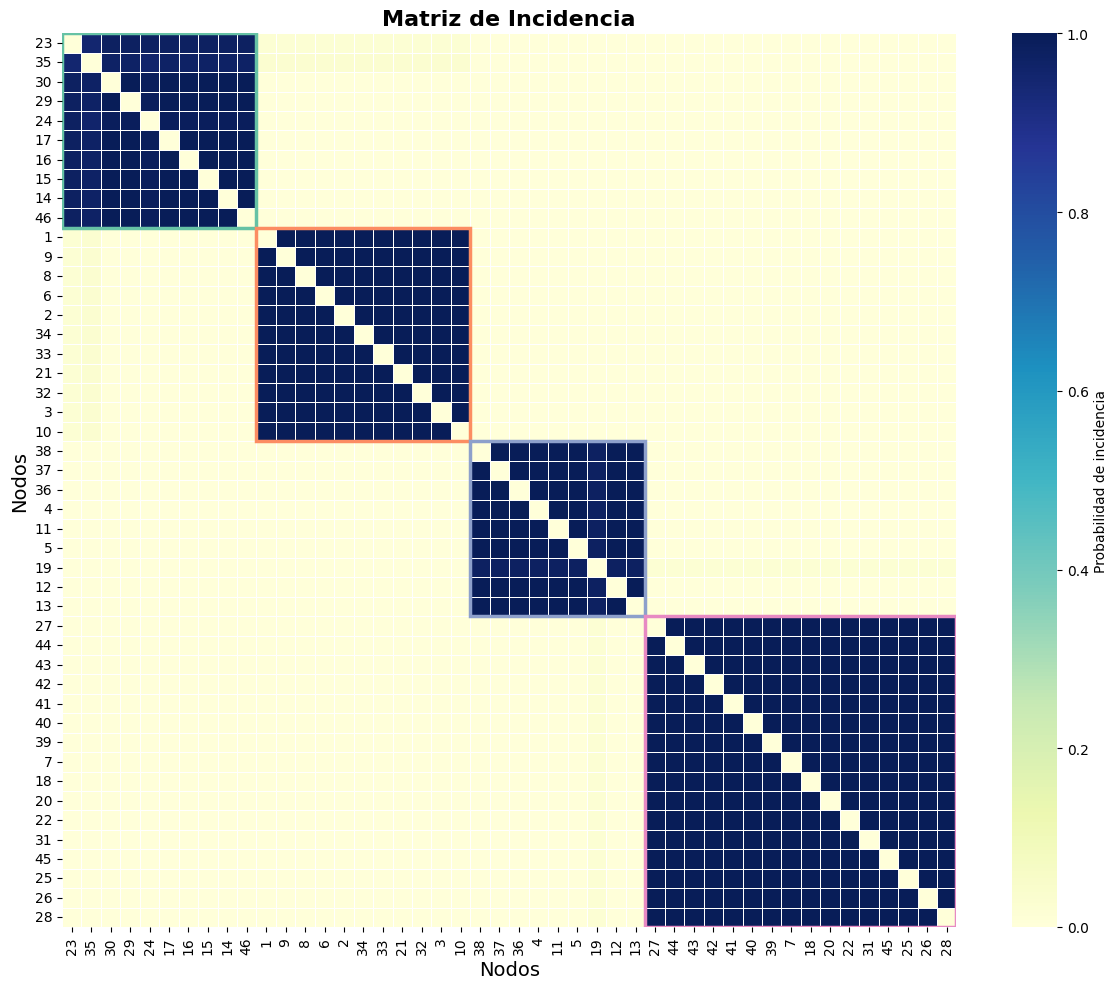

Se han guardado los resultados en archivos para análisis posterior


In [8]:
start_idx = 0  
E_samples_full = trace.posterior["E_vector"].values
print(f"Forma original de E_samples: {E_samples_full.shape}")

if len(E_samples_full.shape) == 3:
    E_samples_filtered = E_samples_full[:, start_idx:, :]
    num_chains = E_samples_filtered.shape[0]
    num_draws_per_chain = E_samples_filtered.shape[1]
    num_nodes = E_samples_filtered.shape[2]
    E_samples = E_samples_filtered.reshape(num_chains * num_draws_per_chain, num_nodes)
else:
    E_samples = E_samples_full.reshape(-1, E_samples_full.shape[-1])
    total_samples = E_samples.shape[0]
    samples_to_keep = total_samples // 2  
    E_samples = E_samples[total_samples - samples_to_keep:, :]

print(f"Forma final de E_samples para análisis: {E_samples.shape}")
print(f"Usando muestras desde la iteración: {start_idx}")

# ---- FUNCIONES AUXILIARES ----
def robust_mode(arr):
    """Encuentra el modo robusto de un array."""
    unique, counts = np.unique(arr, return_counts=True)
    max_count = np.max(counts)
    candidates = unique[counts == max_count]  
    return np.min(candidates)  

num_samples, num_nodes = E_samples.shape

# Create incidence matrix
incidence_matrix = np.zeros((num_nodes, num_nodes))
for sample in E_samples:
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if sample[i] == sample[j]:  
                incidence_matrix[i, j] += 1
                incidence_matrix[j, i] += 1  

incidence_matrix /= num_samples
incidence_matrix_rounded = np.round(incidence_matrix, 2)

E_modes = np.array([robust_mode(E_samples[:, i]) for i in range(num_nodes)])

unique_blocks = np.unique(E_modes)
block_mapping = {block: i for i, block in enumerate(unique_blocks)}
E_modes_mapped = np.array([block_mapping[b] for b in E_modes])

sorted_indices = np.argsort(E_modes_mapped)
incidence_matrix_sorted = incidence_matrix_rounded[np.ix_(sorted_indices, sorted_indices)]
df_sorted = pd.DataFrame(incidence_matrix_sorted, 
                         index=sorted_indices+1, 
                         columns=sorted_indices+1)

block_summary = {}
for block in range(len(unique_blocks)):
    nodes_in_block = np.where(E_modes_mapped == block)[0] + 1  # +1 for 1-indexing
    block_summary[f"Block {block+1}"] = {
        "Nodes": nodes_in_block.tolist(),
        "Count": len(nodes_in_block)
    }

print("\nBloque Assignments Summary (muestras convergentes):")
for block, info in block_summary.items():
    print(f"{block}: {info['Count']} nodes - {info['Nodes']}")

# ---- VISUALIZACIÓN ----
plt.figure(figsize=(12, 10))
elegant_cmap = sns.color_palette("YlGnBu", as_cmap=True)
sns.heatmap(df_sorted, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Probabilidad de incidencia'})
plt.title(f"Matriz de Incidencia", 
          fontsize=16, fontweight='bold')
plt.xlabel("Nodos", fontsize=14)
plt.ylabel("Nodos", fontsize=14)
plt.tick_params(labelsize=10)

current_pos = 0
num_blocks_inferred = len(unique_blocks)
elegant_boundary_palette = sns.color_palette("Set2", num_blocks_inferred)

for block_idx in range(num_blocks_inferred):
    block_size = np.sum(E_modes_mapped[sorted_indices] == block_idx)
    if block_size > 0:
        plt.gca().add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

plt.tight_layout()
plt.savefig(f"Incide_SMB_Macaque.png", dpi=300, bbox_inches='tight')
plt.show()

df_sorted.to_csv(f"matriz_incidencia_desde_{start_idx}.csv")
np.save(f"asignaciones_bloque_desde_{start_idx}.npy", E_modes_mapped)

df_assignments = pd.DataFrame({
    'Node': np.arange(1, num_nodes + 1),
    'Block': E_modes_mapped + 1  # +1 para que los bloques empiecen en 1
})
df_assignments.to_csv(f"asignaciones_nodo_bloque_desde_{start_idx}.csv", index=False)

print(f"Se han guardado los resultados en archivos para análisis posterior")

In [9]:
##CONVERGENCIA DE LA LOG-VEROSIMILITUD

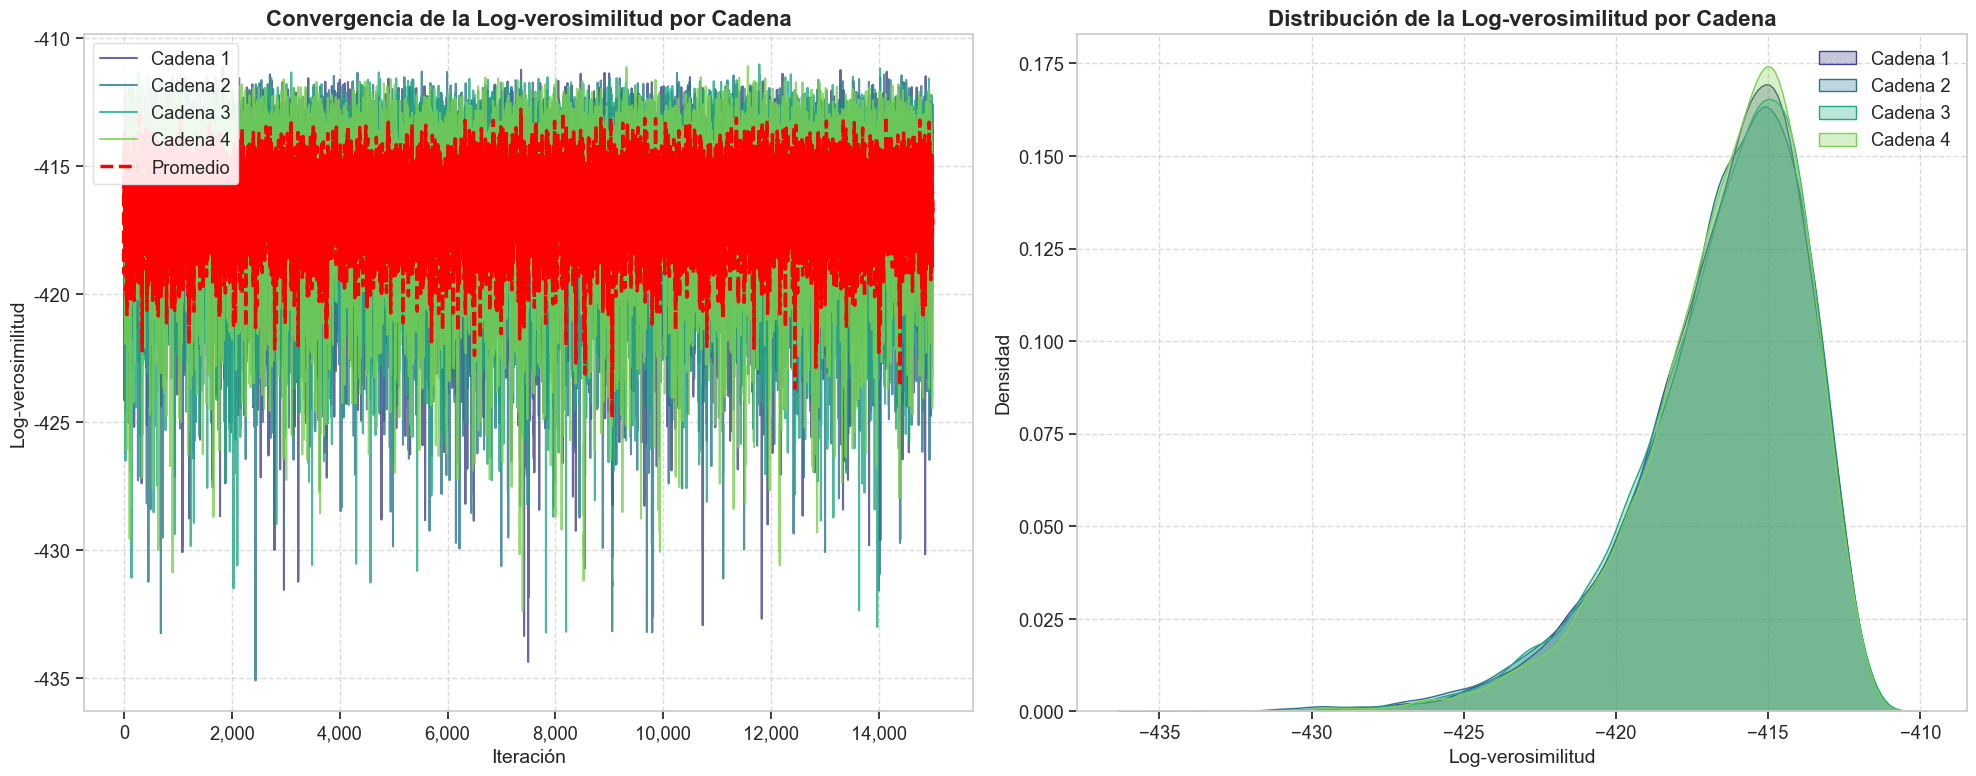

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

log_likelihood = trace.log_likelihood["Y_obs"]
log_posterior = log_likelihood.sum(dim="Y_obs_dim_0")
log_posterior_values = log_posterior.values

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

colors = sns.color_palette("viridis", log_posterior_values.shape[0])

for chain in range(log_posterior_values.shape[0]):
    axes[0].plot(
        np.arange(log_posterior_values.shape[1]), 
        log_posterior_values[chain], 
        label=f"Cadena {chain+1}",
        color=colors[chain],
        linewidth=1.5,
        alpha=0.8
    )

mean_posterior = np.mean(log_posterior_values, axis=0)
axes[0].plot(
    np.arange(mean_posterior.shape[0]), 
    mean_posterior, 
    label="Promedio",
    color="red",
    linewidth=2.5,
    linestyle="--"
)

axes[0].set_xlabel("Iteración", fontsize=14)
axes[0].set_ylabel("Log-verosimilitud", fontsize=14)
axes[0].set_title("Convergencia de la Log-verosimilitud por Cadena", fontsize=16, fontweight='bold')

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

axes[0].grid(True, linestyle='--', alpha=0.7)

axes[0].legend(
    loc='upper left', 
    frameon=True, 
    fancybox=True, 
    framealpha=0.9,
    edgecolor='gainsboro'
)

for chain in range(log_posterior_values.shape[0]):
    sns.kdeplot(
        log_posterior_values[chain],
        ax=axes[1],
        label=f"Cadena {chain+1}",
        color=colors[chain],
        fill=True,
        alpha=0.3
    )

axes[1].set_xlabel("Log-verosimilitud", fontsize=14)
axes[1].set_ylabel("Densidad", fontsize=14)
axes[1].set_title("Distribución de la Log-verosimilitud por Cadena", fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("Log_Post_SMB_macaque.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
def calculate_manual_rhat(chains):
    """Calcula R-hat manualmente"""
    n_chains, n_samples = chains.shape
    
    chain_means = np.mean(chains, axis=1)
    overall_mean = np.mean(chain_means)
    
    B = n_samples * np.sum((chain_means - overall_mean)**2) / (n_chains - 1)
    
    chain_vars = np.var(chains, axis=1, ddof=1)
    W = np.mean(chain_vars)
    
    var_est = ((n_samples - 1) / n_samples) * W + B / n_samples
    
    # R-hat
    r_hat = np.sqrt(var_est / W)
    return r_hat

def calculate_ess_simple(chains):
    """Estimación simple del ESS basada en autocorrelación lag-1"""
    n_chains, n_samples = chains.shape
    
    mean_autocorr = 0
    for chain in chains:
        norm_chain = (chain - np.mean(chain))
        autocorr = np.sum(norm_chain[1:] * norm_chain[:-1]) / np.sum(norm_chain**2)
        mean_autocorr += autocorr / n_chains
    
    #  ESS
    ess = n_chains * n_samples * (1 - mean_autocorr) / (1 + mean_autocorr)
    return ess

def simple_diagnostics(log_posterior_values):
    """
    Calcula versiones simplificadas de ESS y R-hat
    """
    r_hat = calculate_manual_rhat(log_posterior_values)
    ess = calculate_ess_simple(log_posterior_values)
    
    print("\n===== DIAGNÓSTICOS DE CONVERGENCIA SIMPLIFICADOS =====")
    print(f"ESS estimado: {ess:.2f}")
    print(f"R-hat: {r_hat:.4f}")
    
   print("\n===== INTERPRETACIÓN =====")
    if ess < 400:
        print("⚠️ El ESS es bajo. Considere aumentar el número de iteraciones.")
    else:
        print("✓ El ESS es adecuado.")
        
    if r_hat > 1.01:
        print("⚠️ El R-hat es mayor a 1.01. Las cadenas no han convergido completamente.")
    else:
        print("✓ El valor de R-hat indica buena convergencia de las cadenas.")
    
    return ess, r_hat

In [12]:
simple_diagnostics(log_posterior_values)


===== DIAGNÓSTICOS DE CONVERGENCIA SIMPLIFICADOS =====
ESS estimado: 24014.04
R-hat: 1.0001

===== INTERPRETACIÓN =====
✓ El ESS es adecuado.
✓ El valor de R-hat indica buena convergencia de las cadenas.


(24014.039657247384, 1.0001457844796022)

##CONVERGENCIA DE THETA

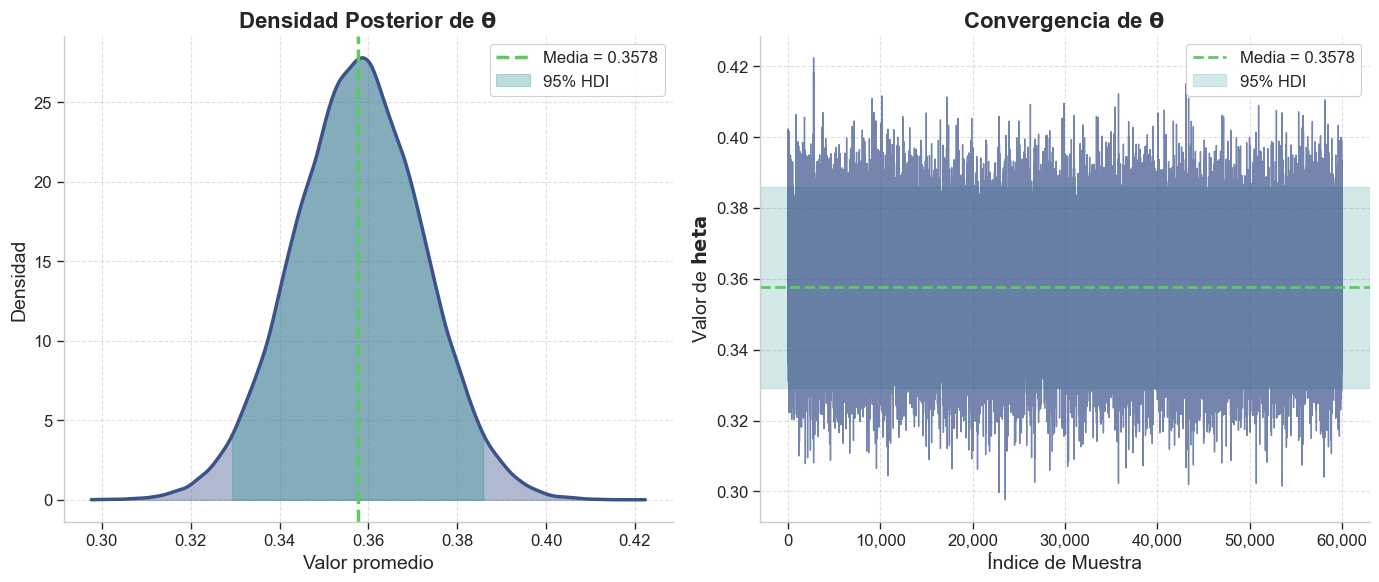

          Estadística     Valor
     Promedio de Mean     0.358
       Promedio de SD     0.014
   Promedio de HDI 3%     0.330
  Promedio de HDI 97%     0.385
Promedio de MCSE Mean     0.000
  Promedio de MCSE SD     0.000
 Promedio de ESS Bulk 79340.000
 Promedio de ESS Tail 46827.000
    Promedio de R hat     1.000


In [28]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
colors = sns.color_palette("viridis", 3)

theta_samples = trace.posterior['Theta_kl'].values  # Forma: (chains, draws, Theta_kl_dim_0)
theta_samples_flattened = theta_samples.reshape(-1, theta_samples.shape[-1])
theta_means_per_sample = theta_samples_flattened.mean(axis=1)

mean_value = theta_means_per_sample.mean()

kde = gaussian_kde(theta_means_per_sample)
x_vals = np.linspace(theta_means_per_sample.min(), theta_means_per_sample.max(), 1000)
y_vals = kde(x_vals)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white')

ax[0].plot(x_vals, y_vals, color=colors[0], linewidth=2.5)
ax[0].fill_between(x_vals, y_vals, color=colors[0], alpha=0.4)
ax[0].axvline(mean_value, color=colors[2], linestyle='--', linewidth=2.5, 
            label=f'Media = {mean_value:.4f}')

lower_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 2.5))
upper_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 97.5))
ax[0].fill_between(x_vals[lower_idx:upper_idx], y_vals[lower_idx:upper_idx], 
                   color=colors[1], alpha=0.3,
                   label='95% HDI')

ax[0].set_title(r'Densidad Posterior de $\mathbf{\theta}$ ', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Valor promedio', fontsize=14)
ax[0].set_ylabel('Densidad', fontsize=14)
ax[0].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].plot(theta_means_per_sample, color=colors[0], alpha=0.7, linewidth=1.0)
ax[1].axhline(y=mean_value, color=colors[2], linestyle='--', linewidth=2, 
             label=f'Media = {mean_value:.4f}')

upper_bound = np.percentile(theta_means_per_sample, 97.5)
lower_bound = np.percentile(theta_means_per_sample, 2.5)
ax[1].axhspan(lower_bound, upper_bound, alpha=0.2, color=colors[1], label='95% HDI')

ax[1].set_title(r'Convergencia de $\mathbf{\theta}$ ', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Índice de Muestra', fontsize=14)
ax[1].set_ylabel('Valor de $\mathbf{\theta}$', fontsize=14)
ax[1].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12, loc='upper right')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

plt.tight_layout()
plt.savefig("convTheta_SBM_macaque.png", dpi=300, bbox_inches="tight")
plt.show()

theta_samples = trace.posterior['Theta_kl'].values  # (chains, draws, dim)
theta_means_per_chain = theta_samples.mean(axis=-1)  # (chains, draws)
# Convertir a xarray
theta_means_xr = xr.DataArray(
    theta_means_per_chain,
    dims=["chain", "draw"],
    name="theta_mean"
)
inference_data = az.from_dict(posterior={"theta_mean": theta_means_xr})
summary_df = az.summary(inference_data, var_names=["theta_mean"], hdi_prob=0.94)

stats = {
    "Promedio de Mean": summary_df["mean"].values[0],
    "Promedio de SD": summary_df["sd"].values[0],
    "Promedio de HDI 3%": summary_df["hdi_3%"].values[0],
    "Promedio de HDI 97%": summary_df["hdi_97%"].values[0],
    "Promedio de MCSE Mean": summary_df["mcse_mean"].values[0],
    "Promedio de MCSE SD": summary_df["mcse_sd"].values[0],
    "Promedio de ESS Bulk": summary_df["ess_bulk"].values[0],
    "Promedio de ESS Tail": summary_df["ess_tail"].values[0],
    "Promedio de R hat": summary_df["r_hat"].values[0],
}
tabla_estadisticas = pd.DataFrame({
    "Estadística": list(stats.keys()),
    "Valor": [round(v, 4) for v in stats.values()]
})
print(tabla_estadisticas.to_string(index=False))

##PRESICION 

Generando redes...
Calculando estadísticas de red...
Calculando PPP-values...
Generando visualizaciones...


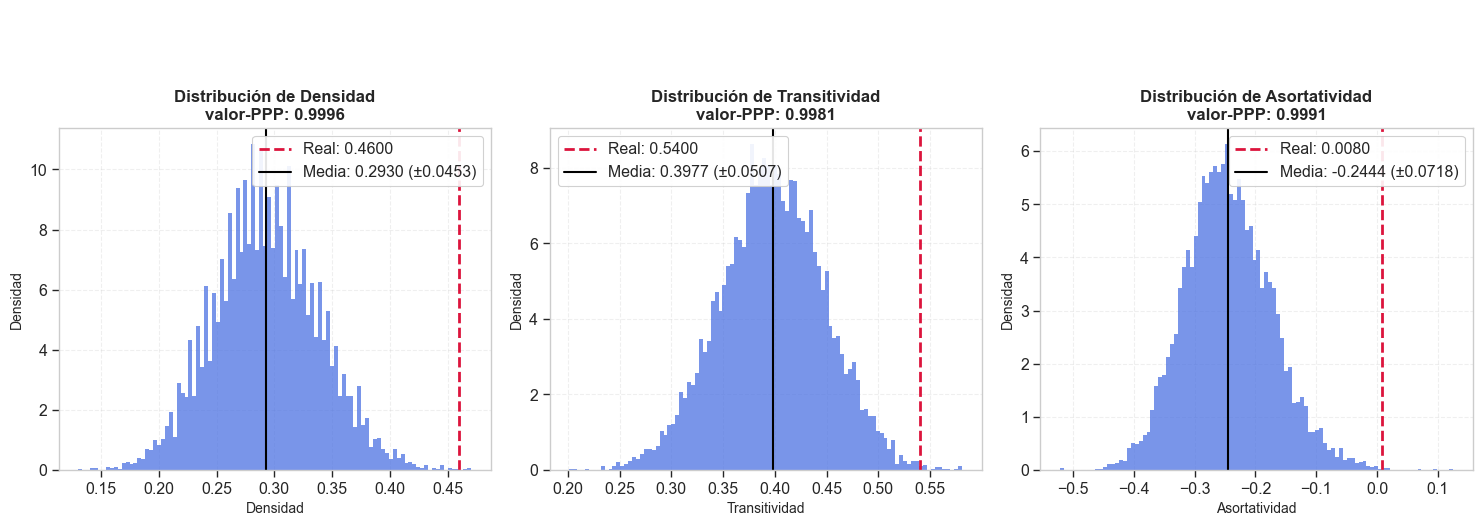


===== RESUMEN DE ESTADÍSTICAS CON PPP-VALUES =====

DENSIDAD:
  Real:              0.4600
  Media Simulada:    0.2930
  Desviación Std:    0.0453
  Error Absoluto:    0.1670
  Error Relativo:    36.29%
  PPP-value:         0.9996
  Interpretación:    SUBESTIMACIÓN: El modelo genera valores consistentemente menores que el real.

TRANSITIVIDAD:
  Real:              0.5400
  Media Simulada:    0.3977
  Desviación Std:    0.0507
  Error Absoluto:    0.1423
  Error Relativo:    26.35%
  PPP-value:         0.9981
  Interpretación:    SUBESTIMACIÓN: El modelo genera valores consistentemente menores que el real.

ASORTATIVIDAD:
  Real:              0.0080
  Media Simulada:    -0.2444
  Desviación Std:    0.0718
  Error Absoluto:    0.2524
  Error Relativo:    3154.76%
  PPP-value:         0.9991
  Interpretación:    SUBESTIMACIÓN: El modelo genera valores consistentemente menores que el real.


In [32]:
def reconstruct_interaction_matrix(theta_samples: np.ndarray) -> np.ndarray:
    """
    Reconstruye la matriz completa de probabilidades de interacción a partir de muestras.
    
    Args:
        theta_samples: Array de muestras con forma 3D o 4D
        
    Returns:
        Array 3D de matrices de interacción reconstruidas
    """
    if theta_samples.ndim == 4:
        theta_samples = theta_samples.reshape(-1, theta_samples.shape[2], theta_samples.shape[3])
    
    return theta_samples


def safe_assortativity(G: nx.Graph) -> float:
    """
    Cálculo seguro de asortatividad con múltiples métodos de respaldo.
    
    Args:
        G: Grafo de NetworkX
        
    Returns:
        Coeficiente de asortatividad o 0 si no se puede calcular
    """
    try:
        assort = nx.degree_assortativity_coefficient(G)
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    try:
        nx.set_node_attributes(G, {n: np.random.random() for n in G.nodes()}, 'random_attr')
        assort = nx.attribute_assortativity_coefficient(G, 'random_attr')
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    return 0  


def generate_networks(
    interaction_matrices: np.ndarray, 
    num_nodes: int, 
    num_blocks: int, 
    networks_per_matrix: int = 2000
) -> List[nx.Graph]:
    """
    Genera múltiples redes basadas en los parámetros muestreados.
    
    Args:
        interaction_matrices: Array de matrices de interacción
        num_nodes: Número de nodos en cada red
        num_blocks: Número de bloques en el modelo
        networks_per_matrix: Número de redes a generar por matriz
        
    Returns:
        Lista de grafos generados
    """
    networks = []
    
    for matrix in interaction_matrices:
        for _ in range(networks_per_matrix):
            block_assignments = np.random.randint(0, num_blocks, size=num_nodes)
            
            G = nx.Graph()
            G.add_nodes_from(range(num_nodes))
            
            edges = []
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    block_i, block_j = block_assignments[i], block_assignments[j]
                    if np.random.random() < matrix[block_i, block_j]:
                        edges.append((i, j))
            
            G.add_edges_from(edges)
            networks.append(G)
    
    return networks


def compute_network_statistics(networks: List[nx.Graph]) -> Dict[str, List[float]]:
    """
    Calcula estadísticas de red: densidad, transitividad, asortatividad.
    
    Args:
        networks: Lista de grafos de NetworkX
        
    Returns:
        Diccionario con estadísticas calculadas
    """
    stats = {
        'densidad': [],
        'transitividad': [],
        'asortatividad': []
    }
    
    for G in networks:
        
        stats['densidad'].append(nx.density(G))
        
        try:
            transitivity = nx.transitivity(G)
            stats['transitividad'].append(transitivity if not np.isnan(transitivity) else 0)
        except (nx.NetworkXError, ZeroDivisionError):
            stats['transitividad'].append(0)
        
        stats['asortatividad'].append(safe_assortativity(G))
    
    return stats


def calculate_ppp_values(stats: Dict[str, List[float]], real_stats: Dict[str, float]) -> Dict[str, float]:
    """
    Calcula los valores PPP (posterior predictive p-values) para las estadísticas dadas.
    
    Args:
        stats: Diccionario con listas de estadísticas calculadas de las redes simuladas
        real_stats: Diccionario con valores reales de referencia
        
    Returns:
        Diccionario con los valores PPP para cada estadística
    """
    ppp_values = {}
    
    for stat_name in stats.keys():
        # NaN
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        #  PPP-value (proporción de simulaciones más extremas que el valor real)
        ppp_value = np.mean(valid_stats <= real_stats[stat_name])
        
        ppp_values[stat_name] = ppp_value
    
    return ppp_values


def interpret_ppp_values(ppp_values: Dict[str, float]) -> Dict[str, str]:
    """
    Interpreta los valores PPP para cada estadística.
    
    Args:
        ppp_values: Diccionario con valores PPP calculados
        
    Returns:
        Diccionario con interpretaciones para cada estadística
    """
    interpretations = {}
    
    for stat_name, ppp in ppp_values.items():
        if 0.05 <= ppp <= 0.95:
            interpretations[stat_name] = "ACEPTABLE: El modelo reproduce adecuadamente esta estadística."
        elif ppp < 0.05:
            interpretations[stat_name] = "SOBRESTIMACIÓN: El modelo genera valores consistentemente mayores que el real."
        else:  # ppp > 0.95
            interpretations[stat_name] = "SUBESTIMACIÓN: El modelo genera valores consistentemente menores que el real."
    
    return interpretations


def plot_statistics_comparison(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float],
    ppp_values: Dict[str, float],
    output_file: Optional[str] = "precision_estMSBSIM2.png"
) -> plt.Figure:
    """
    Compara las estadísticas de red generadas con los valores reales y muestra PPP.
    
    Args:
        stats: Diccionario con estadísticas calculadas
        real_stats: Diccionario con valores reales de referencia
        ppp_values: Diccionario con valores PPP calculados
        output_file: Nombre del archivo para guardar la figura
        
    Returns:
        Figura de matplotlib
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    stat_names = ['densidad', 'transitividad', 'asortatividad']
    
    for i, stat_name in enumerate(stat_names):
        #  NaN
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        #  estadísticas
        posterior_mean = np.mean(valid_stats)
        posterior_std = np.std(valid_stats)
        
        # Histograma 
        axes[i].hist(valid_stats, bins=min(100, len(valid_stats)//50 + 10), 
                    density=True, alpha=0.7, color='royalblue')  # Cambiado a 'royalblue'
        
        # Valor real
        axes[i].axvline(real_stats[stat_name], color='crimson', linestyle='--', linewidth=2,
                       label=f'Real: {real_stats[stat_name]:.4f}')
        
        # Media posterior
        axes[i].axvline(posterior_mean, color='black', linestyle='-', linewidth=1.5,
                       label=f'Media: {posterior_mean:.4f} (±{posterior_std:.4f})')
        
        axes[i].set_title(f'Distribución de {stat_name.capitalize()}\nvalor-PPP: {ppp_values[stat_name]:.4f}', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel(stat_name.capitalize(), fontsize=10)
        axes[i].set_ylabel('Densidad', fontsize=10)
        axes[i].grid(alpha=0.3, linestyle='--')
        axes[i].legend(loc='best', frameon=True, framealpha=0.9)
    
    plt.suptitle(' ', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    # Guardar figura si se especificó un nombre de archivo
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig


def summarize_statistics(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float]
) -> Dict[str, Dict[str, float]]:
    """
    Genera un resumen de estadísticas comparando valores reales y simulados.
    
    Args:
        stats: Diccionario con estadísticas calculadas
        real_stats: Diccionario con valores reales de referencia
        
    Returns:
        Diccionario con resumen de estadísticas
    """
    summary = {}
    
    for stat_name in ['densidad', 'transitividad', 'asortatividad']:
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        summary[stat_name] = {
            'real': real_stats[stat_name],
            'media': np.mean(valid_stats),
            'desv_std': np.std(valid_stats),
            'mediana': np.median(valid_stats),
            'error_abs': abs(real_stats[stat_name] - np.mean(valid_stats)),
            'error_rel': abs(real_stats[stat_name] - np.mean(valid_stats)) / (abs(real_stats[stat_name]) + 1e-10) * 100
        }
    
    return summary


def main():
    # Parámetros reales
    real_stats = {
        'densidad': 0.46,
        'transitividad': 0.54,
        'asortatividad': 0.008
    }

    # Reconstrucción de matrices
    theta_samples = trace.posterior['Theta_kl'].values
    interaction_matrices = reconstruct_interaction_matrix(theta_samples)

    # Generar redes
    print("Generando redes...")
    networks = generate_networks(
        interaction_matrices, 
        num_nodes=46,  
        num_blocks=8,
        networks_per_matrix=2000
    )

    # Cálculo de estadísticas
    print("Calculando estadísticas de red...")
    network_stats = compute_network_statistics(networks)
    
    # Calcular PPP-values
    print("Calculando PPP-values...")
    ppp_values = calculate_ppp_values(network_stats, real_stats)
    
    # Interpretar PPP-values
    interpretations = interpret_ppp_values(ppp_values)

    # Visualización de comparación con PPP-values
    print("Generando visualizaciones...")
    fig = plot_statistics_comparison(network_stats, real_stats, ppp_values)
    plt.savefig("presicion_SBM_macaque_ppp.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Resumen de estadísticas
    summary = summarize_statistics(network_stats, real_stats)
    
    print("\n===== RESUMEN DE ESTADÍSTICAS CON PPP-VALUES =====")
    for stat_name, values in summary.items():
        print(f"\n{stat_name.upper()}:")
        print(f"  Real:              {values['real']:.4f}")
        print(f"  Media Simulada:    {values['media']:.4f}")
        print(f"  Desviación Std:    {values['desv_std']:.4f}")
        print(f"  Error Absoluto:    {values['error_abs']:.4f}")
        print(f"  Error Relativo:    {values['error_rel']:.2f}%")
        print(f"  PPP-value:         {ppp_values[stat_name]:.4f}")
        print(f"  Interpretación:    {interpretations[stat_name]}")


if __name__ == "__main__":
    main()